In [ ]:
#https://www.geeksforgeeks.org/implementing-neural-networks-using-tensorflow/

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

df = pd.read_csv('/Users/sherryzhang/Downloads/NNFinal_Balanced_Data.csv')  # Change the path to your dataset
df.head()

,AGEP,ANC1P,CIT,DIS,SCHL,ESR,HICOV,HISP,PINCP,OCCP,MAR,MIG,MIL,RAC1P,POBP,SEX,poverty_status
0,51,999,1,1,17.0,6.0,1,1,12500.0,9645.0,2,1.0,4.0,1,1,1,1
1,49,50,1,1,19.0,6.0,2,1,5000.0,6230.0,3,3.0,2.0,1,1,1,1
2,31,939,1,2,17.0,6.0,2,1,12300.0,4020.0,5,3.0,4.0,2,1,1,1
3,21,903,1,2,19.0,6.0,1,1,2400.0,9130.0,5,1.0,4.0,2,48,1,1
4,20,22,1,1,10.0,1.0,1,1,8640.0,9620.0,5,3.0,4.0,1,21,1,1


In [10]:
train_df = df.sample(frac=0.6, random_state=4)

temp_df = df.drop(train_df.index)
val_df = temp_df.sample(frac=0.5, random_state=4)
test_df = temp_df.drop(val_df.index)

In [11]:
max_val = train_df.max(axis=0)
min_val = train_df.min(axis=0)
range_val = max_val - min_val

train_df = (train_df - min_val) / range_val
val_df = (val_df - min_val) / range_val
test_df = (test_df - min_val) / range_val

In [12]:
X_train = train_df.drop('poverty_status', axis=1)
X_val = val_df.drop('poverty_status', axis=1)
X_test = test_df.drop('poverty_status', axis=1)
y_train = train_df['poverty_status']
y_val = val_df['poverty_status']
y_test = test_df['poverty_status']

input_shape = [X_train.shape[1]]
input_shape

[16]

In [13]:
model = Sequential([
    Dense(128, input_shape=(X_train.shape[1],), activation='relu', kernel_regularizer='l2'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer='l2'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(32, activation='relu', kernel_regularizer='l2'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.summary()

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 128)            │         2,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,441 (52.50 KB)

 Trainable params: 12,993 (50.75 KB)

 Non-trainable params: 448 (1.75 KB)

In [14]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [15]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

In [16]:
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=50,
                    batch_size=256,
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/50
1954/1954 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.6302 - loss: 2.0904 - val_accuracy: 0.7771 - val_loss: 1.1669 - learning_rate: 1.0000e-04
Epoch 2/50
1954/1954 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7427 - loss: 1.0961 - val_accuracy: 0.7943 - val_loss: 0.7034 - learning_rate: 1.0000e-04
Epoch 3/50
1954/1954 ━━━━━━━━━━━━━━━━━━━━ 2s 944us/step - accuracy: 0.8013 - loss: 0.6416 - val_accuracy: 0.9859 - val_loss: 0.1598 - learning_rate: 1.0000e-04
Epoch 4/50
1954/1954 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9614 - loss: 0.1870 - val_accuracy: 0.9776 - val_loss: 0.0950 - learning_rate: 1.0000e-04
Epoch 5/50
1954/1954 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9755 - loss: 0.0997 - val_accuracy: 0.9957 - val_loss: 0.0451 - learning_rate: 1.0000e-04
Epoch 6/50
1954/1954 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9808 - loss: 0.0707 - val_accuracy: 0.9784 - val_loss: 0.0618 - learning_rate: 1.0000e-04
Epoch 7/50
1954/1954 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/s

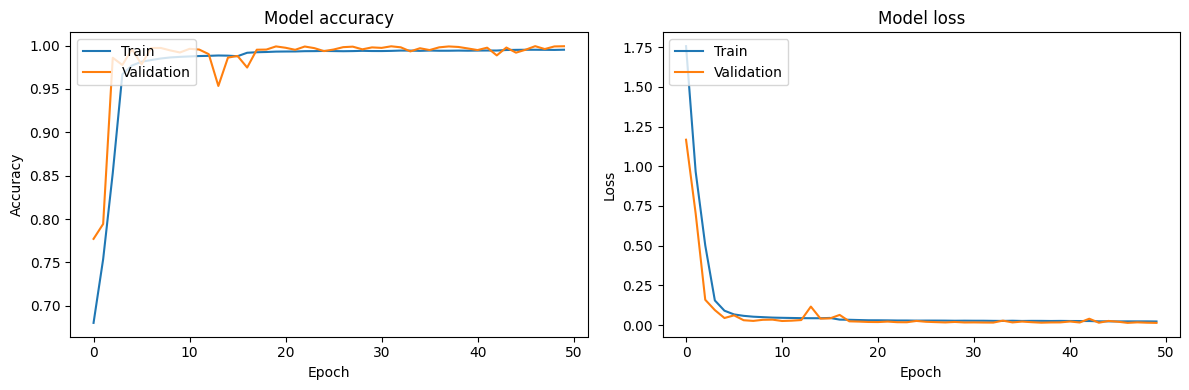

In [17]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [18]:
y_pred_prob_test = model.predict(X_test)
y_pred_test = np.where(y_pred_prob_test > 0.5, 1, 0)

5211/5211 ━━━━━━━━━━━━━━━━━━━━ 1s 192us/step


In [19]:
accuracy_test = accuracy_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test, zero_division=1)
recall_test = recall_score(y_test, y_pred_test, zero_division=1)
f1_test = f1_score(y_test, y_pred_test, zero_division=1)

print(f'Test Accuracy: {accuracy_test:.4f}')
print(f'Test Precision: {precision_test:.4f}')
print(f'Test Recall: {recall_test:.4f}')
print(f'Test F1 Score: {f1_test:.4f}')

Test Accuracy: 0.9993
Test Precision: 0.9991
Test Recall: 0.9995
Test F1 Score: 0.9993
